In [1]:
#importing libraries:
import tensorflow as tf
import cv2
import keras
import matplotlib.pyplot as plt
import os 
import glob as gb 
import pandas as pd 
import numpy as np
import random
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 2. Data Preparation:

# 2.1 Load and visualize the data

In [2]:
locat_training="../input/brain-tumor-mri-dataset/Training"
locat_testing = "../input/brain-tumor-mri-dataset/Testing"
locat_checkpoints='model1_weights.h5'

In [3]:
v=0
for folder in os.listdir(locat_training):
    files=gb.glob(pathname=str(locat_training+"//"+folder+"/*.jpg"))
    x= len(files)
    v=v+x
    print(f"the training images in folder {folder} is {len(files)} ")
print(f"the total images is {v}")

the training images in folder pituitary is 1457 
the training images in folder notumor is 1595 
the training images in folder meningioma is 1339 
the training images in folder glioma is 1321 
the total images is 5712


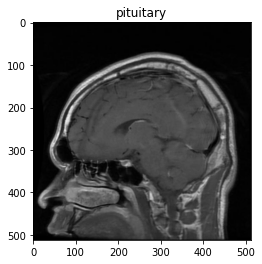

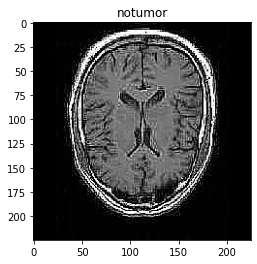

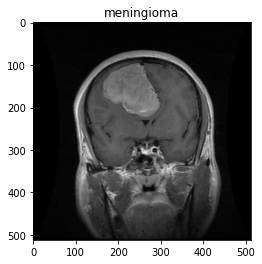

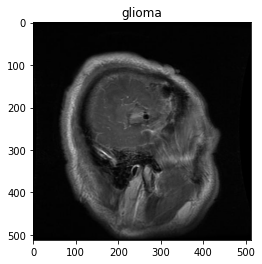

The size of training set is 5712 
(512, 512)    3955
(225, 225)     268
(630, 630)      77
(236, 236)      53
(251, 201)      43
              ... 
(293, 216)       1
(310, 329)       1
(202, 216)       1
(253, 278)       1
(412, 300)       1
Length: 382, dtype: int64


In [4]:
train_size=[]
for folder in os.listdir(locat_training):
    x=0
    files=gb.glob(pathname=str(locat_training+"//"+folder+"/*.jpg"))
    for file in files:
        img=cv2.imread(file,cv2.IMREAD_GRAYSCALE)
        train_size.append(img.shape)
        x=x+1
        if x<=1:
            plt.imshow(img, cmap='gray')
            plt.title(folder)
            plt.show()
            
print(f"The size of training set is {len(train_size)} ")
print(pd.Series(train_size).value_counts())

In [5]:
v=0
for folder in os.listdir(locat_testing):
    files=gb.glob(pathname=str(locat_testing+"//"+folder+"/*.jpg"))
    x= len(files)
    v=v+x
    print(f"the testing images in folder {folder} is {len(files)} ")
print(f"the total images is {v}")

the testing images in folder pituitary is 300 
the testing images in folder notumor is 405 
the testing images in folder meningioma is 306 
the testing images in folder glioma is 300 
the total images is 1311


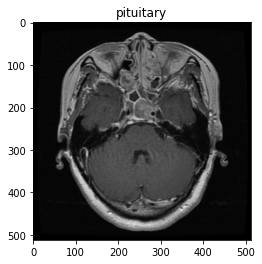

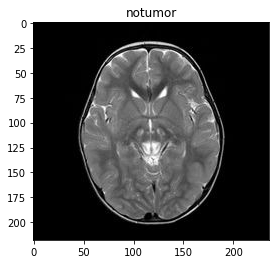

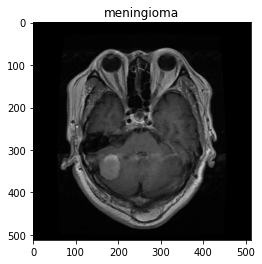

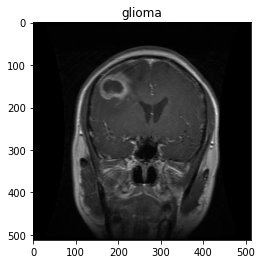

The size of testing set is 1311 
(512, 512)    787
(225, 225)     64
(236, 236)     28
(222, 227)     17
(217, 232)     15
             ... 
(257, 221)      1
(249, 201)      1
(351, 321)      1
(393, 350)      1
(306, 306)      1
Length: 194, dtype: int64


In [6]:
test_size=[]
for folder in os.listdir(locat_testing):
    x=0
    files=gb.glob(pathname=str(locat_testing+"//"+folder+"/*.jpg"))
    for file in files:
        img=cv2.imread(file,cv2.IMREAD_GRAYSCALE)
        test_size.append(img.shape)
        x=x+1
        if x<=1:
            plt.imshow(img, cmap='gray')
            plt.title(folder)
            plt.show()

print(f"The size of testing set is {len(test_size)} ")
print(pd.Series(test_size).value_counts())

# 2.2 Data augmentation

In [7]:
img_size=80
train_datagen=ImageDataGenerator(rotation_range=5,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1.0/255.0 )

train_generator=train_datagen.flow_from_directory(locat_training,
    class_mode='binary',
    color_mode='grayscale',
    batch_size=32,
    target_size=(img_size,img_size)
)

Found 5712 images belonging to 4 classes.


In [8]:
test_datagen=ImageDataGenerator(rescale=1.0/255.0 )
test_generator=train_datagen.flow_from_directory(
    locat_testing,
    class_mode='binary',
    color_mode='grayscale',
    batch_size=32,
    target_size=(img_size,img_size)
)

Found 1311 images belonging to 4 classes.


# 3.1 let's build CNN model :

In [9]:
filter_size=(5,5)
model=keras.models.Sequential([
    
    keras.layers.Conv2D(32,kernel_size=filter_size,activation='relu',input_shape=(img_size,img_size,1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(.2),
    
    keras.layers.Conv2D(64,kernel_size=filter_size,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(.2),
    
    keras.layers.Conv2D(128,kernel_size=filter_size,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(.2),

    keras.layers.Conv2D(128,kernel_size=filter_size,activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2,2)),
    keras.layers.Dropout(.2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(.2),
    keras.layers.Dense(512,activation='relu'),
    keras.layers.Dropout(.2),
    
    keras.layers.Dense(4,activation='softmax')
])

2022-10-27 23:33:37.985231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 23:33:38.084793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 23:33:38.085550: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-27 23:33:38.086477: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0001, clipvalue=0.5)

model.compile(optimizer =optimizer,loss='sparse_categorical_crossentropy',metrics= ['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 76, 76, 32)        832       
_________________________________________________________________
batch_normalization (BatchNo (None, 76, 76, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 38, 38, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 38, 38, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 34, 34, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 64)        0

In [12]:
model_es = EarlyStopping(monitor = 'loss',  patience =5 , verbose = 1)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 6, verbose = 1)
model_mcp = ModelCheckpoint(filepath =locat_checkpoints, monitor = 'val_categorical_accuracy', save_best_only = True, verbose = 1)

In [13]:
epoch=50
history=model.fit(train_generator, 
    epochs=epoch,
    validation_data=test_generator,
    callbacks=[model_es, model_rlr, model_mcp])

2022-10-27 23:33:41.074098: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-10-27 23:33:42.883215: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


179/179 [==============================] - 31s 128ms/step - loss: 0.7734 - accuracy: 0.7038 - val_loss: 1.9658 - val_accuracy: 0.3143
Epoch 2/50
179/179 [==============================] - 24s 135ms/step - loss: 0.5147 - accuracy: 0.8079 - val_loss: 2.0248 - val_accuracy: 0.5088
Epoch 3/50
179/179 [==============================] - 24s 132ms/step - loss: 0.3984 - accuracy: 0.8552 - val_loss: 1.4398 - val_accuracy: 0.6224
Epoch 4/50
179/179 [==============================] - 23s 127ms/step - loss: 0.3155 - accuracy: 0.8846 - val_loss: 0.4188 - val_accuracy: 0.8513
Epoch 5/50
179/179 [==============================] - 23s 127ms/step - loss: 0.2846 - accuracy: 0.8967 - val_loss: 0.8111 - val_accuracy: 0.7635
Epoch 6/50
179/179 [==============================] - 22s 124ms/step - loss: 0.2554 - accuracy: 0.9112 - val_loss: 0.3535 - val_accuracy: 0.8658
Epoch 7/50
179/179 [==============================] - 23s 129ms/step - loss: 0.2401 - accuracy: 0.9125 - val_loss: 0.5034 - val_accuracy: 0.8

In [14]:
model.evaluate(test_generator)

41/41 [==============================] - 4s 98ms/step - loss: 0.0340 - accuracy: 0.9878


[0.03402736037969589, 0.9877955913543701]

Text(0.5, 1.0, 'Loss')

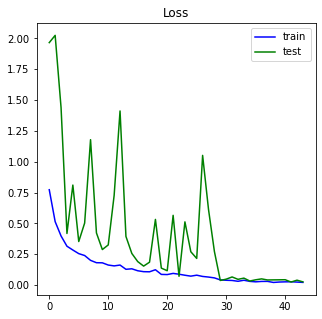

In [15]:


import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(history.history["loss"],c = "blue")
plt.plot(history.history["val_loss"],c = "green")
plt.legend(["train", "test"])
plt.title('Loss')

Text(0.5, 1.0, 'Accuracy')

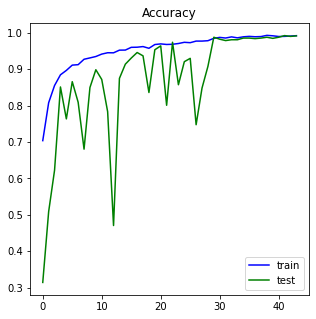

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(history.history["accuracy"],c = "blue")
plt.plot(history.history["val_accuracy"],c = "green")
plt.legend(["train", "test"])
plt.title('Accuracy')

In [17]:
model.save('brain.h5')